<a href="https://colab.research.google.com/github/minyoungci/DeepLearning/blob/master/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

R-CNN: https://arxiv.org/abs/1311.2524
### R-CNN

* 객체 탐지에 사용된 초기 모델
* 주요 객체들을 바운딩 박스로 표현하여 정확히 식별하는 것이 목표
* Selective Search를 통해 다양한 크기의 박스를 만들고, region proposal 영역 생성
* region proposal 영역을 warp 하여 표준화된 크기로 변환 
* AlexNet을 개량한 CNN 모델을 이용하고, 마지막 층에 SVM을 통해 객체 분류

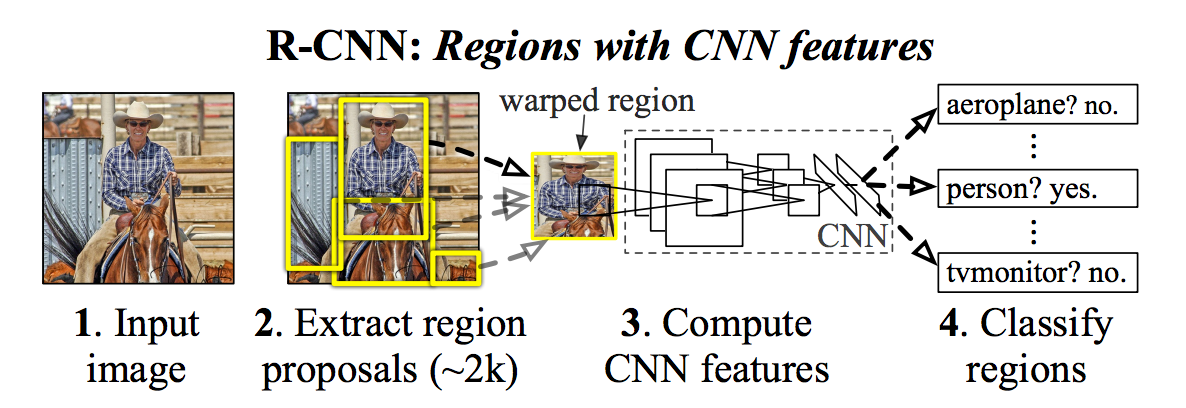

https://arxiv.org/abs/1504.08083
### Fast R-CNN

* R-CNN의 단점인 느린 속도를 빠른 속도로 개선
* ROI(Region of Interest) 풀링을 통해 한 이미지의 subregion에 대한 forward pass 값을 공유
* R-CNN은 CNN 모델로 image feature를 추출, SVM 모델로 분류, Regressor 모델로 bounding box를 맞추는 작업으로 분류되어 있지만, Fast R-CNN은 하나의 모델로 동작
* Top layer에 softmax layer를 둬서 CNN 결과를 class로 출력
* Box regression layer를 softmax layer에 평행하게 두어 bounding box 좌표를 출력

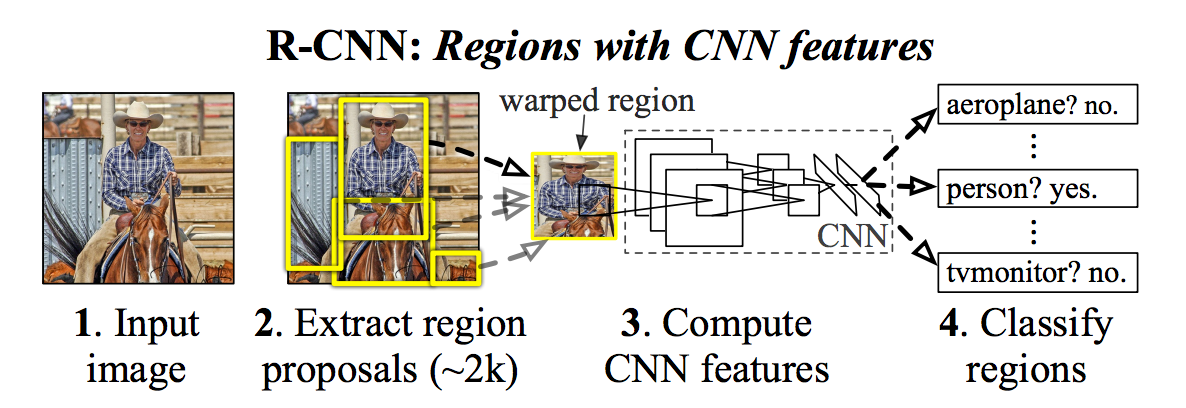

* Faster R-CNN: https://arxiv.org/abs/1506.01497
  - Fast R-CNN은 가능성 있는 다양한 bounding box들, 즉 ROI를 생성하는 과정인 selective search가 느려 region proposer에서 병목이 발생
  - 이미지 분류(classification)의 첫 단계인 CNN의 forward pass를 통해 얻어진 feature들을 기반으로 영역을 제안
  - CNN 결과를 selective search 알고리즘 대신 region proposal에 이용

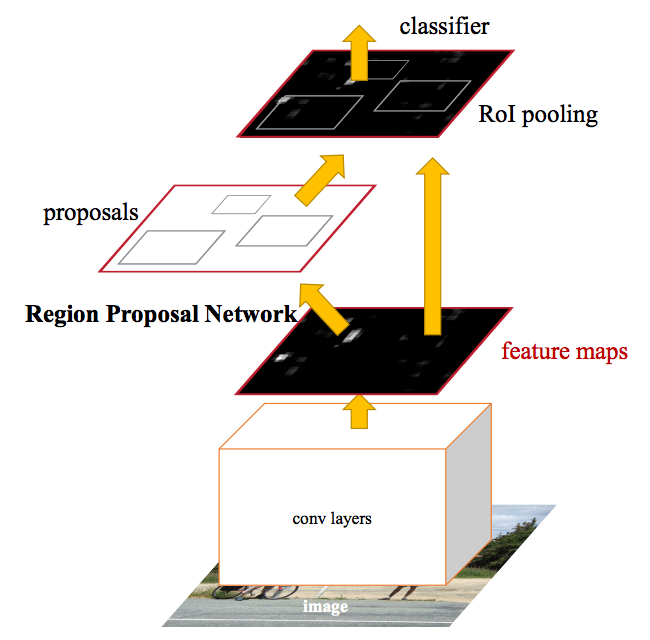

* k개의 일반적인 비율을 지닌 anchor box를 이용하여 하나의 bounding box 및 score를 이미지의 위치별로 출력

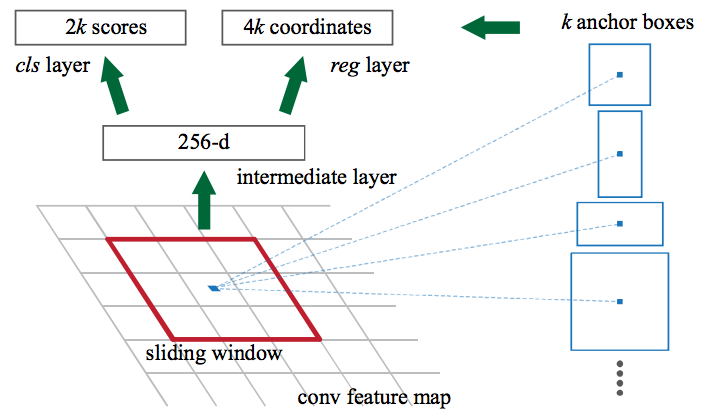

# U-Net 기반 세그멘테이션

- 사용된 모델은 수정된 U-Net(https://arxiv.org/abs/1505.04597)
- U-Net이라 불리는 인코더(다운샘플링)와 디코더(업샘플링)를 포함한 구조는 정교한 픽셀 단위의 segmentation이 요구되는 biomedical image segmentation task의 핵심 요소
- Encoder-decoder 구조 또한 semantic segmentation을 위한 CNN 구조로 자주 활용
- Encoder 부분에서는 점진적으로 spatial dimension을 줄여가면서 고차원의 semantic 정보를 convolution filter가 추출해낼 수 있게 함
- Decoder 부분에서는 encoder에서 spatial dimension 축소로 인해 손실된 spatial 정보를 점진적으로 복원하여 보다 정교한 boundary segmentation을 완성
- U-Net은 기본적인 encoder-decoder 구조와 달리 Spatial 정보를 복원하는 과정에서 이전 encoder feature map 중 동일한 크기를 지닌 feature map을 가져 와 prior로 활용함으로써 더 정확한 boundary segmentation이 가능하게 함

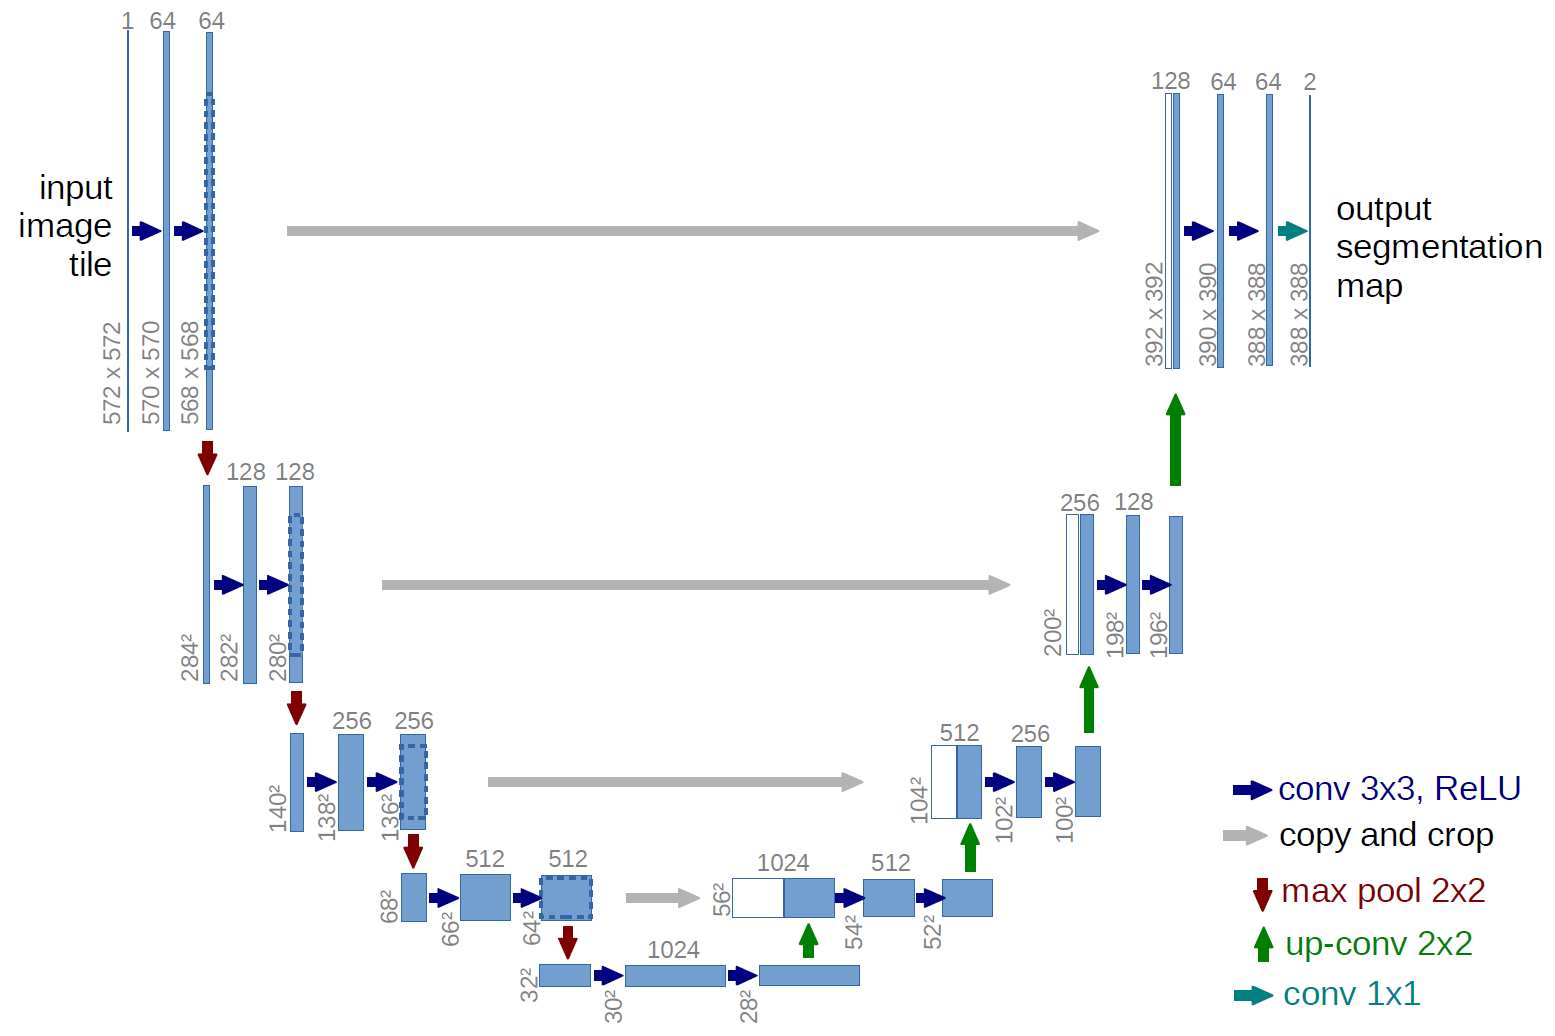

## Oxford-IIIT Pets 데이터셋

- Parkhi *et al*이 만든 [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) 데이터 세트는 영상, 해당 레이블과 픽셀 단위의 마스크로 구성
- 마스크는 기본적으로 각 픽셀의 레이블
- 각 픽셀은 다음 세 가지 범주 중 하나
  *   class 1 : 애완동물이 속한 픽셀
  *   class 2 : 애완동물과 인접한 픽셀
  *   class 3 : 위에 속하지 않는 경우/주변 픽셀

- Images: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
- Annotations: https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!curl -OL https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -OL https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   350  100   350    0     0    438      0 --:--:-- --:--:-- --:--:--   438
100  755M  100  755M    0     0  20.3M      0  0:00:37  0:00:37 --:--:-- 22.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   355  100   355    0     0    444      0 --:--:-- --:--:-- --:--:--   444
100 18.2M  100 18.2M    0     0  5729k      0  0:00:03  0:00:03 --:--:-- 12.8M


* 현재 input_dir인 images와 file name을 가져옵니다. 
* input_dir에서 file name을 하나씩 꺼내어 .jpg 확장자만 가져오도록 조건문 설정
* 동일하게 target에 대해서도 정의해줌.

In [ ]:
import os 

input_dir = 'images'
target_dir = 'annotations/trimaps'
img_size = (160,160) # 이미지 사이즈가 160x160
num_classes = 3
batch_size = 32 

input_img_paths = sorted([os.path.join(input_dir, fname)
                                        for fname in os.listdir(input_dir)
                                        if fname.endswith('.jpg')])

target_img_paths = sorted([os.path.join(target_dir, fname)
                                        for fname in os.listdir(target_dir)
                                        if fname.endswith('.png') and not fname.startswith(".")])

In [ ]:
input_img_paths

['images/Abyssinian_1.jpg',
 'images/Abyssinian_10.jpg',
 'images/Abyssinian_100.jpg',
 'images/Abyssinian_101.jpg',
 'images/Abyssinian_102.jpg',
 'images/Abyssinian_103.jpg',
 'images/Abyssinian_104.jpg',
 'images/Abyssinian_105.jpg',
 'images/Abyssinian_106.jpg',
 'images/Abyssinian_107.jpg',
 'images/Abyssinian_108.jpg',
 'images/Abyssinian_109.jpg',
 'images/Abyssinian_11.jpg',
 'images/Abyssinian_110.jpg',
 'images/Abyssinian_111.jpg',
 'images/Abyssinian_112.jpg',
 'images/Abyssinian_113.jpg',
 'images/Abyssinian_114.jpg',
 'images/Abyssinian_115.jpg',
 'images/Abyssinian_116.jpg',
 'images/Abyssinian_117.jpg',
 'images/Abyssinian_118.jpg',
 'images/Abyssinian_119.jpg',
 'images/Abyssinian_12.jpg',
 'images/Abyssinian_120.jpg',
 'images/Abyssinian_121.jpg',
 'images/Abyssinian_122.jpg',
 'images/Abyssinian_123.jpg',
 'images/Abyssinian_124.jpg',
 'images/Abyssinian_125.jpg',
 'images/Abyssinian_126.jpg',
 'images/Abyssinian_127.jpg',
 'images/Abyssinian_128.jpg',
 'images/Abyssi

In [ ]:
target_img_paths

['annotations/trimaps/Abyssinian_1.png',
 'annotations/trimaps/Abyssinian_10.png',
 'annotations/trimaps/Abyssinian_100.png',
 'annotations/trimaps/Abyssinian_101.png',
 'annotations/trimaps/Abyssinian_102.png',
 'annotations/trimaps/Abyssinian_103.png',
 'annotations/trimaps/Abyssinian_104.png',
 'annotations/trimaps/Abyssinian_105.png',
 'annotations/trimaps/Abyssinian_106.png',
 'annotations/trimaps/Abyssinian_107.png',
 'annotations/trimaps/Abyssinian_108.png',
 'annotations/trimaps/Abyssinian_109.png',
 'annotations/trimaps/Abyssinian_11.png',
 'annotations/trimaps/Abyssinian_110.png',
 'annotations/trimaps/Abyssinian_111.png',
 'annotations/trimaps/Abyssinian_112.png',
 'annotations/trimaps/Abyssinian_113.png',
 'annotations/trimaps/Abyssinian_114.png',
 'annotations/trimaps/Abyssinian_115.png',
 'annotations/trimaps/Abyssinian_116.png',
 'annotations/trimaps/Abyssinian_117.png',
 'annotations/trimaps/Abyssinian_118.png',
 'annotations/trimaps/Abyssinian_119.png',
 'annotations/t

* 인풋과 타겟 모두 파일들이 잘 저장되었습니다. 
* 리스트로 확인하면 복잡하니까 이미지를 띄어ㅝ서 확인해보겠습니다.

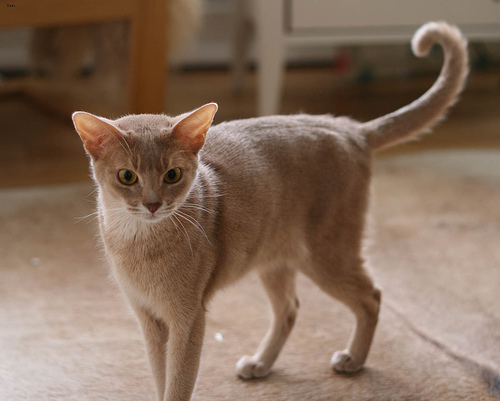

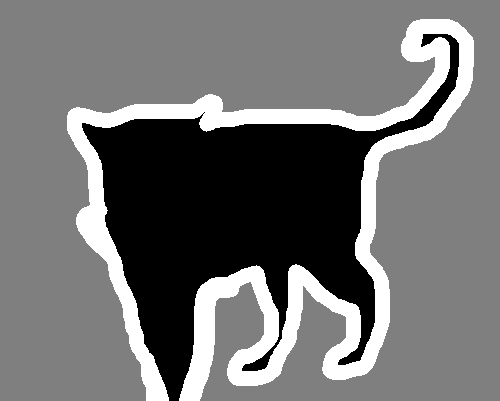

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

display(Image(filename=input_img_paths[20])) # input_img_paths에 저장된 이미지들 중 7번째 이미지만 display
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[20])) # annotation 이미지도 같이 출력하기
# autocontrast는 밝은 픽셀과 어두운 픽셀의 이미지 대비를 최대화(표준화)합니다. 
display(img)

# 데이터 전처리

In [ ]:
import numpy as np 
from tensorflow import keras

class OxfordPets(keras.utils.Sequence):
  def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_img_paths = input_img_paths
    self.target_img_paths = target_img_paths 

  def __len__(self):
    return len(self.target_img_paths) // self.batch_size

  def __getitem__(self, idx):
    i = idx * self.batch_size 
    batch_input_img_paths = self.input_img_paths[i:i+self.batch_size]
    batch_target_img_paths = self.input_img_paths[i:i+self.batch_size] # i는 배치 사이즈 만큼 계속 증가 
    x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32') # np.zeros로 빈공간 생성 , 빈공간에 임지를 불러서 넣을 것임. 
    
    for j,path in enumerate(batch_input_img_paths):
      img = load_img(path, target_size=self.image_size)
      x[j] = img
    y = np.zeros((self.batch_size,) + self.img_size + (1,) , dtype="unit8")

    for j,path in enumerate(batch_target_img_paths):
      img = load_img(path, target_size=self.image_size, color_mode="grayscale")
      y[j] = np.expand_dims(img,2)
      y[j] -= 1 

    return x,y # 입력값 X , 정답값 y 

In [ ]:
import random # random한 데이터 

val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples] # 훈련용 데이터 
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:] # 검증용 데이터 
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths )
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths )

# 모델 구성

## U-NET 을 따라 만들어야함.

In [ ]:
from tensorflow.keras import layers 

def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size+(3,))

  x = layers.Conv2D(32, 3, srides=2, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)